In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [12]:
df = pd.read_csv('data.csv')

In [13]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


First couple of obvious data cleaning matters:
1. ID column is not really relevant, I'll drop it so that later I can maybe feed the entire dataframe into a model
2. Going to turn diagnosis into a proper dummy: 1 = malignant, 0 = benign
3. Last column - 'unnamed -32' is meaningless, let's drop it

In [14]:
df.drop(['id','Unnamed: 32'], axis=1, inplace =True)
df['diagnosis'] = [1 if df.loc[n]['diagnosis']=='M' else 0 for n in range(0,len(df))]
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Basic EDA reveals some of the key aspects of this data set. In particular, area/radius/perimeter are clearly the same thing. Their being split into three groups (for 3X3 = 9 total columns) may lead you to suspect that there is some subtle but possibly crucially significant difference between them, but upon graphing any combination it's clear that common sense wins out and that they are pretty fundamentally just transformations of the same data. 2 of these categories are redundant.

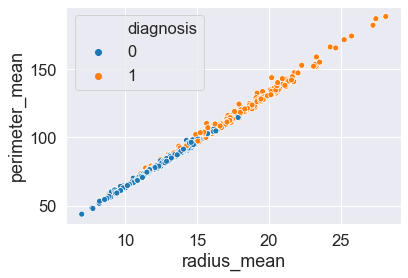

In [155]:
sns.scatterplot(x='radius_mean', y='perimeter_mean', hue='diagnosis', data=df)

Another clear insight is that a substantial amount of the variance between malignant and benign (the lion's share even) comes from the size. Pretty much any scatter plot that includes radius makes it clear that below a certain size (around 10) all of the cases are benign and that above a certain size (around 17) all the cases are malginant. The task becomes simply finding the features that best illumniate the space in between. It may even make better sense to evaluate the final model only on cases in this band: a simple logistic regression taking into account only the mean radius feature with no scaling or any other work already scores in the 80s for both accuracy and F1.

The main goal of EDA is therefore to try and zoom in on this decision boundary and find the things that look most significant there.

I'm also going to start out engineering by creating two flags related to radius to mark off those cases that sit well within the 'so small they're never malignant' or within the 'so large they're always malignant cases'.

In [18]:
df['low_radius_mean'] = [1 if df.loc[n]['radius_mean']<10.5 else 0 for n in range(0,len(df))]
df['high_radius_mean'] = [1 if df.loc[n]['radius_mean']>18 else 0 for n in range(0,len(df))]

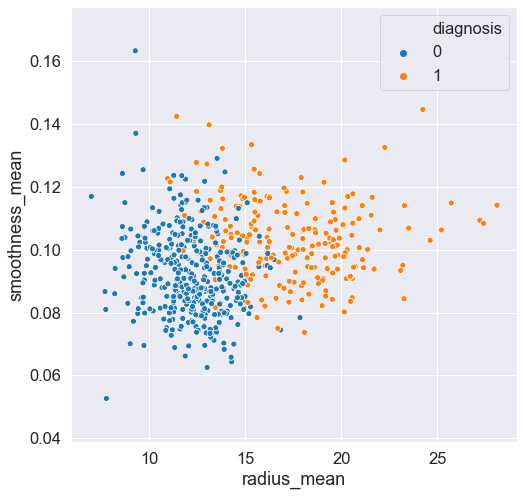

In [156]:
#smoothness doesn't look like it provides a whole lot of extra info. Symmetry also appears to be useless
plt.figure(figsize=(8,8))
sns.scatterplot(x='radius_mean', y='smoothness_mean', hue='diagnosis', data=df)

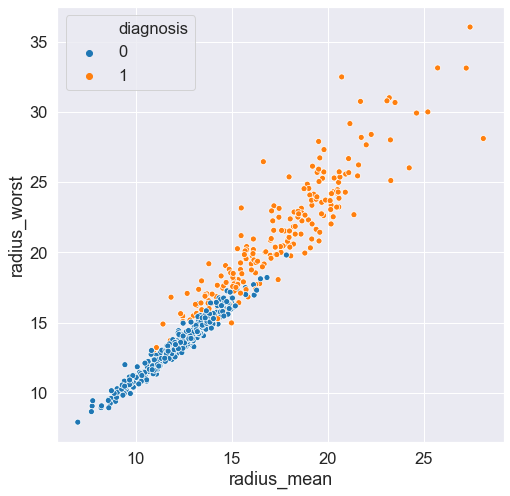

In [157]:
#using the radius_worst in addition to the radius does look like it adds value though - for the marginal cases
#instances with higher worst radii are more likely to be malignant
plt.figure(figsize=(8,8))
sns.scatterplot(x='radius_mean', y='radius_worst', hue='diagnosis', 
                data=df)

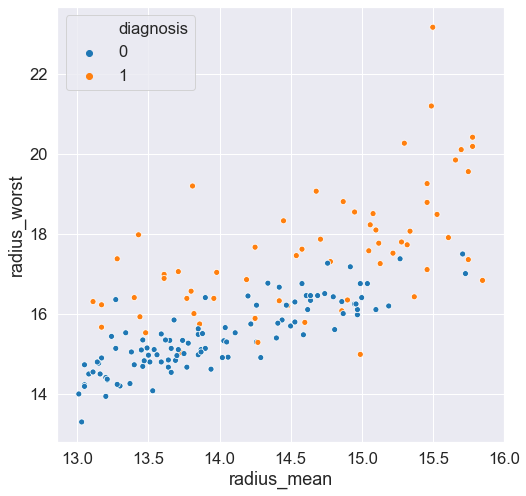

In [158]:
#zooming in on the marginal area to better illustrate:
plt.figure(figsize=(8,8))
sns.scatterplot(x='radius_mean', y='radius_worst', hue='diagnosis', 
                data=df[(df['radius_mean']>13)&(df['radius_mean']<16)])

This has some real power, but it's clearly a little non-linear: looking over on the left hand side, cases with mean radii of around 13.25 - 13.5 seem to move into the malignant range when the radius of the worst instance hits 16, but more towards the middle of the graph, cases with mean radii around 14.5 or 15 seem to regularly remain benign with worst instances of 16.

Perhaps a better marker here is how much bigger the worst case is than the average:

In [22]:
df['percent_higher_worst'] = df['radius_worst']/df['radius_mean'] -1

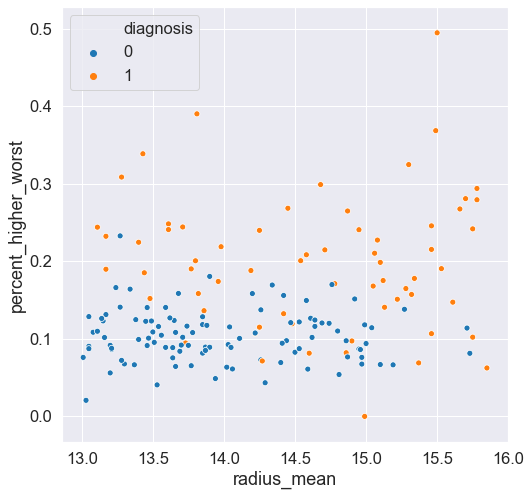

In [159]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='radius_mean', y='percent_higher_worst', hue='diagnosis', 
                data=df[(df['radius_mean']>13)&(df['radius_mean']<16)])

This looks like it works a little better to me. It provides a clearer decision boundary: if the worst instance is 17/18% more than the average, it's much more likely to be malignant. 

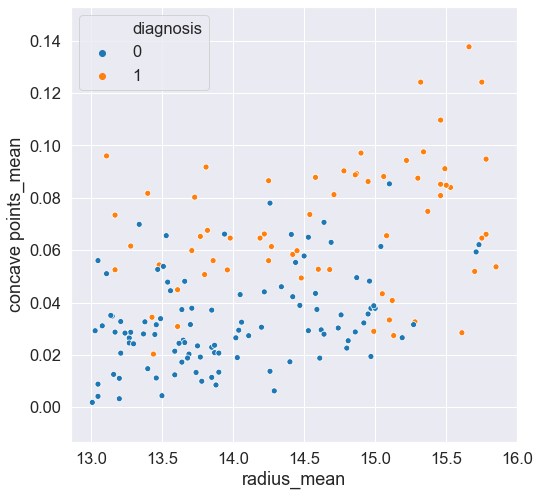

In [160]:
# concave points also looks valuable on the margin, with the worst value looking a little cleaner than the mean
#This one doesn't seem to benefit much from the percentage transformation.
plt.figure(figsize=(8,8))
sns.scatterplot(x='radius_mean', y='concave points_mean', hue='diagnosis', 
                data=df[(df['radius_mean']>13)&(df['radius_mean']<16)])

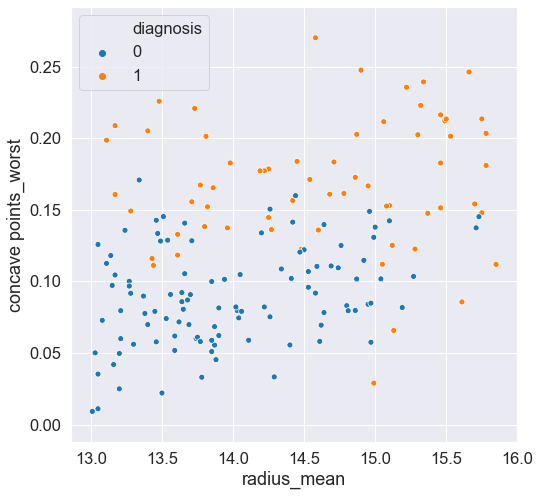

In [161]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='radius_mean', y='concave points_worst', hue='diagnosis', 
                data=df[(df['radius_mean']>13)&(df['radius_mean']<16)])

Another thing that occured to me was to interact some of these features that seemed to make a difference. Compactness and fractal dimension both seem to add a bit of information on the margin - are there additive effects of scoring higher on both? I would include concave points as well.

In [34]:
df['feature_interaction_worst'] = df['compactness_worst']*df['fractal_dimension_worst']*df['concave points_worst']

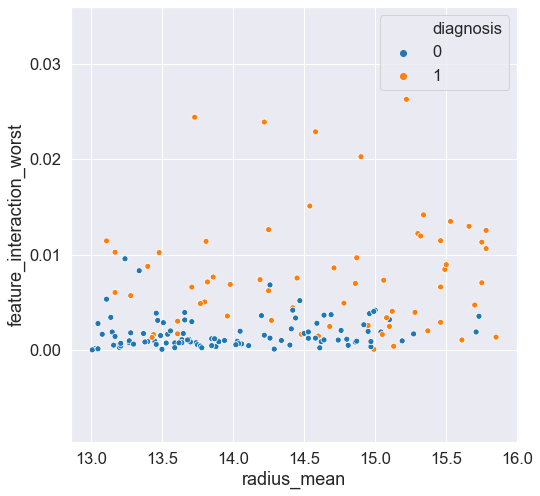

In [162]:
#some benefit, but hard to tell how much value over the just using the original categories.
plt.figure(figsize=(8,8))
sns.scatterplot(x='radius_mean', y='feature_interaction_worst', hue='diagnosis', 
                data=df[(df['radius_mean']>13)&(df['radius_mean']<16)])

The descriptive stats smoothness, symmetry and texture seem to be of little value. It occurs to me that maybe some combination of these stats might have value, but that is hard to visually if the predictive power is hidden across three features. I'm going to dummy out the extreme values of these variables just in case they do have any value. I had originally planned to interact them, but the numbers end up being too small to be trustworthy.

In [44]:
df['high_smooth'] = [1 if df.loc[n]['smoothness_mean'] > .105 else 0 for n in range(0,len(df))]
df['low_smooth'] = [1 if df.loc[n]['smoothness_mean'] <.086 else 0 for n in range(0,len(df))]
df['high_texture'] = [1 if df.loc[n]['texture_mean'] > 21.8 else 0 for n in range(0,len(df))]
df['low_texture'] = [1 if df.loc[n]['texture_mean'] <16.1 else 0 for n in range(0,len(df))]
df['high_symmetry'] = [1 if df.loc[n]['symmetry_mean'] > .195 else 0 for n in range(0,len(df))]
df['low_symmetry'] = [1 if df.loc[n]['symmetry_mean'] <.16 else 0 for n in range(0,len(df))]

In [48]:
#To test my baseline models across numerous splits, given that the overall population is small and may be more
#easily influenced by the circumstances of the split
def log_reg_tester(feature_set,iterations):
    f1_values = []
    accuracy_values = []
    for n in range(0,iterations):
        X_train, X_test, y_train, y_test = train_test_split(df[feature_set], df['diagnosis'])
        logreg = LogisticRegression()
        logreg.fit(X_train,y_train)
        y_pred = logreg.predict(X_test)
        f1_values.append(f1_score(y_pred, y_test))
        accuracy_values.append(accuracy_score(y_pred, y_test))
    print('Average accuracy: ',sum(accuracy_values)/iterations)
    print('Average F1 score: ',sum(f1_values)/iterations)
    pass

In [49]:
#As you can see, using simply the radius itself in a simple logistic regression is already pretty accurate
log_reg_tester(['radius_mean'],50)

Average accuracy:  0.8864335664335663
Average F1 score:  0.8245788266798195


In [51]:
log_reg_tester(['radius_mean','percent_higher_worst','compactness_mean','concave points_mean'],50)

Average accuracy:  0.9061538461538459
Average F1 score:  0.857876417502278


In [54]:
#Including the obviously helpful features and some of our interactions already adds 10% to the F1 score.
log_reg_tester(['radius_mean','low_radius_mean','high_radius_mean','feature_interaction_worst',
                 'compactness_mean','concave points_mean','radius_worst','percent_higher_worst'],50)

Average accuracy:  0.9434965034965036
Average F1 score:  0.9201513739550216


Now the plan is to iterate over different models to find a best performing model with the fewest number of moving parts. Since this is such a small overall sample, I think I would definitely value a model with fewer features or a tree that isn't very deep. I also think that cross validation is going to be very important. Grid search will do that for me, but for the very simple models, I will continue to do as above, running the model multiple times with different splits.

Goals/things to test:
1. What is the best set of features? And in particular which measure of area seems most useful? I've defaulted to using radius, but maybe area is slightly more useful. They're so highly correlated that it doesn't make a whole lot of sense to use both, but maybe one will perform slightly better than the other
2. Ordinary logistic regression
3. Logistic regression on normalized features
4. KNN
5. Decision tree - but with a short max depth. Anything more than couple of branches you'll quickly have nodes with only a couple of rows in them
6. Random forest

First I'm going to iterate through different combinations of features and measures of area using logistic regression to find a best performing feature set.

In [71]:
#minor tweak to my logistic regression testing function so it simply returns the average f1 rather than printing
#the stats
def log_reg_iter(feature_set,iterations):
    f1_values = []
    accuracy_values = []
    for n in range(0,iterations):
        X_train, X_test, y_train, y_test = train_test_split(df[feature_set], df['diagnosis'])
        logreg = LogisticRegression()
        logreg.fit(X_train,y_train)
        y_pred = logreg.predict(X_test)
        f1_values.append(f1_score(y_pred, y_test))
        accuracy_values.append(accuracy_score(y_pred, y_test))
    return sum(f1_values)/iterations

from itertools import combinations

def iteration_tester(measures_of_area, features, model, n_tests):
    iterations_of_features = list(combinations(features,4))
    for n in range(5,len(features)):
        iterations_of_features = iterations_of_features + list(combinations(features,n))

    iterations_of_features.append(tuple(features))
    measure_of_area = str()
    set_of_features = []
    highest_f1 = 0
    for measure in measures_of_area:
        for iteration in iterations_of_features:
            f1 = model(list(iteration) + [measure],n_tests)
            if f1 > highest_f1:
                measure_of_area = measure
                set_of_features = list(iteration)
                highest_f1 = f1
    print('Measure of area: ',measure_of_area)
    print('Other features: ',set_of_features)
    print('Average f1 score: ',highest_f1)
    pass

In [69]:
measures_of_area = ['radius_mean','area_mean','perimeter_mean']
features = ['low_radius_mean','high_radius_mean','feature_interaction_worst',
                 'compactness_mean','concave points_mean','radius_worst','percent_higher_worst']

iteration_tester(measures_of_area, features, log_reg_iter, 100)


Measure of area:  radius_mean
Other features:  ['low_radius_mean', 'high_radius_mean', 'feature_interaction_worst', 'compactness_mean', 'radius_worst']
Average f1 score:  0.9190782397633569


In [70]:
log_reg_tester(['radius_mean','low_radius_mean', 'high_radius_mean', 'feature_interaction_worst', 
                'compactness_mean', 'radius_worst'],50)

Average accuracy:  0.9379020979020981
Average F1 score:  0.91171391429109


It looks like radius mean is consistently the most useful measure of area. It also looks like you get results that are about as good as using every one of the obvious feature candidates and engineered features by using only 5 of them, a result I like since I favor fewer features.

Going to do a similar process with logistic regression but using scaled features.

In [78]:
from sklearn.preprocessing import StandardScaler

def scaled_log_reg_iter(feature_set,iterations):
    f1_values = []
    accuracy_values = []
    for n in range(0,iterations):
        X_train, X_test, y_train, y_test = train_test_split(df[feature_set], df['diagnosis'])
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        logreg = LogisticRegression()
        logreg.fit(X_train,y_train)
        y_pred = logreg.predict(X_test)
        f1_values.append(f1_score(y_pred, y_test))
        accuracy_values.append(accuracy_score(y_pred, y_test))
    return sum(f1_values)/iterations

In [79]:
measures_of_area = ['radius_mean','area_mean','perimeter_mean']
features = ['low_radius_mean','high_radius_mean','feature_interaction_worst',
                 'compactness_mean','concave points_mean','radius_worst','percent_higher_worst']

iteration_tester(measures_of_area, features, scaled_log_reg_iter, 50)

Measure of area:  perimeter_mean
Other features:  ['low_radius_mean', 'high_radius_mean', 'feature_interaction_worst', 'compactness_mean', 'concave points_mean', 'radius_worst', 'percent_higher_worst']
Average f1 score:  0.9548533890921892


Three results I'm not sure I expected: a) Perimeter mean is now the favored measure of size b) the model now favors using all of the features and c) I've gained fully 3% to F1 from scaling. While maybe I shouldn't be so surprised at that, very little in the EDA looked super non-linear, so I am.

In [80]:
def scaled_log_reg_tester(feature_set,iterations):
    f1_values = []
    accuracy_values = []
    for n in range(0,iterations):
        X_train, X_test, y_train, y_test = train_test_split(df[feature_set], df['diagnosis'])
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        logreg = LogisticRegression()
        logreg.fit(X_train,y_train)
        y_pred = logreg.predict(X_test)
        f1_values.append(f1_score(y_pred, y_test))
        accuracy_values.append(accuracy_score(y_pred, y_test))
    print('Average accuracy: ',sum(accuracy_values)/iterations)
    print('Average F1 score: ',sum(f1_values)/iterations)
    pass

In [81]:
# 96% accuracy and 95% F1 is already pretty high, given the size of the sample at this point we're fighting for
#a handful of correct classifications
scaled_log_reg_tester(['perimeter_mean','low_radius_mean','high_radius_mean','feature_interaction_worst',
                 'compactness_mean','concave points_mean','radius_worst','percent_higher_worst'],50)

Average accuracy:  0.9674125874125878
Average F1 score:  0.9539657800148653


Going to run something similar with KNN, first cycling through values for K and then trying combinations of features. KNN takes a little longer to fit than other models, but since it's a relatively small sample/feature set, I think I'll be able to cycle through everything without too much difficulty.

In [94]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_test(feature_set,iterations,k):
    f1_values = []
    accuracy_values = []
    for n in range(0,iterations):
        X_train, X_test, y_train, y_test = train_test_split(df[feature_set], df['diagnosis'])
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        f1_values.append(f1_score(y_pred, y_test))
        accuracy_values.append(accuracy_score(y_pred, y_test))
    return sum(f1_values)/iterations

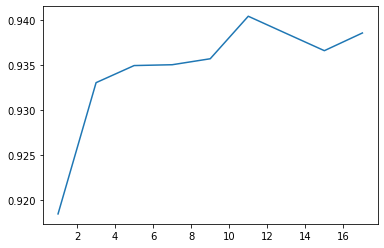

In [96]:
features = ['radius_mean','low_radius_mean','high_radius_mean','feature_interaction_worst',
                 'compactness_mean','concave points_mean','radius_worst','percent_higher_worst']
k_list = list(range(1,19,2))
f1_list = []
for k in k_list:
    f1_list.append(KNN_test(features,100,k))
plt.plot(k_list,f1_list)

In [97]:
# looks like a slightly higher k, 9 or 11, is where F1 tops out
def KNN_iter_test(feature_set,iterations):
    f1_values = []
    accuracy_values = []
    for n in range(0,iterations):
        X_train, X_test, y_train, y_test = train_test_split(df[feature_set], df['diagnosis'])
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        knn = KNeighborsClassifier(n_neighbors = 9)
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        f1_values.append(f1_score(y_pred, y_test))
        accuracy_values.append(accuracy_score(y_pred, y_test))
    return sum(f1_values)/iterations

measures_of_area = ['radius_mean','area_mean','perimeter_mean']
features = ['low_radius_mean','high_radius_mean','feature_interaction_worst',
                 'compactness_mean','concave points_mean','radius_worst','percent_higher_worst']

iteration_tester(measures_of_area, features, KNN_iter_test, 50)

Measure of area:  area_mean
Other features:  ['high_radius_mean', 'feature_interaction_worst', 'concave points_mean', 'radius_worst', 'percent_higher_worst']
Average f1 score:  0.9474281666517457


KNN appears to max out just shy of the scaled logistic regression. 

Final two model types will be decision tree and random forest. Given the size of the data set, I'm a little skeptical of these, honestly. I think it will be easy to get nodes at the bottom of the tree that are very small, I suspect that generalizable performance will drop off if you get more than couple of branches... But then, the first couple of splits are likely to be so powerful regardless, given tha thte first split is likely just to break off high sized/low sized cases.

In [105]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
parameters={'criterion': ['gini','entropy'], 
            'min_samples_leaf' : range(1,20),
            'max_depth': range(2,10)}

decisiontree=DecisionTreeClassifier()
features = ['radius_mean','area_mean','perimeter_mean','radius_mean','low_radius_mean','high_radius_mean',
            'feature_interaction_worst','compactness_mean','concave points_mean','radius_worst',
            'percent_higher_worst','high_smooth','low_smooth','high_texture','low_texture',
           'high_symmetry','low_symmetry']
X_train, X_test, y_train, y_test = train_test_split(df[features], df['diagnosis'])

grid_tree=GridSearchCV(decisiontree, parameters, cv=5, scoring='f1',n_jobs=-1,verbose=2)
grid_tree.fit(X_train,y_train)

Fitting 5 folds for each of 304 candidates, totalling 1520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1520 out of 1520 | elapsed:    1.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(1, 20), 'max_depth': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [107]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
y_pred = grid_tree.best_estimator_.predict(X_test)
print('accuracy: ',accuracy_score(y_pred, y_test))
print('f1: ',f1_score(y_pred, y_test))

0.9292408324623306
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}
accuracy:  0.9300699300699301
f1:  0.9180327868852459


In [110]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
features = ['radius_mean','area_mean','perimeter_mean','radius_mean','low_radius_mean','high_radius_mean',
            'feature_interaction_worst','compactness_mean','concave points_mean','radius_worst',
            'percent_higher_worst','high_smooth','low_smooth','high_texture','low_texture',
           'high_symmetry','low_symmetry']
X_train, X_test, y_train, y_test = train_test_split(df[features], df['diagnosis'])

parameters={'criterion': ['gini','entropy'],
            'n_estimators':range(50,300,25),
            'min_samples_leaf' : range(1,20),
            'max_depth': range(2,10)}
grid_tree=GridSearchCV(rfc, parameters, cv=5, scoring='f1',n_jobs=-1,verbose=2)
grid_tree.fit(X_train,y_train)

Fitting 5 folds for each of 3040 candidates, totalling 15200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': range(50, 300, 25), 'min_samples_leaf': range(1, 20), 'max_depth': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [111]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
y_pred = grid_tree.best_estimator_.predict(X_test)
print('accuracy: ',accuracy_score(y_pred, y_test))
print('f1: ',f1_score(y_pred, y_test))


0.9486799268732359
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 250}
accuracy:  0.972027972027972
f1:  0.9636363636363636


It looks like we've found a winner in terms of F1 - this random forest manages to get us up to 97% accuracy on the test set and 96% for F1. 

In [112]:
from sklearn.metrics import confusion_matrix


array([[86,  1],
       [ 3, 53]])

In [117]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[86  1]
 [ 3 53]]


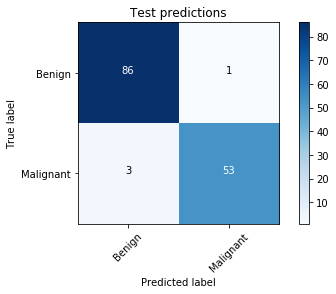

In [125]:
cm = confusion_matrix(y_test,y_pred)
classes = ['Benign','Malignant']
plot_confusion_matrix(cm, classes, title="Test predictions", normalize=False)

Confusion Matrix, without normalization
[[270   0]
 [  4 152]]


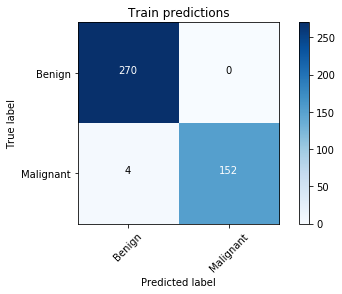

In [126]:
y_train_pred = grid_tree.best_estimator_.predict(X_train)
cm = confusion_matrix(y_train,y_train_pred)
classes = ['Benign','Malignant']
plot_confusion_matrix(cm, classes, title="Train predictions", normalize=False)

Confusion Matrix, without normalization
[[356   1]
 [  7 205]]


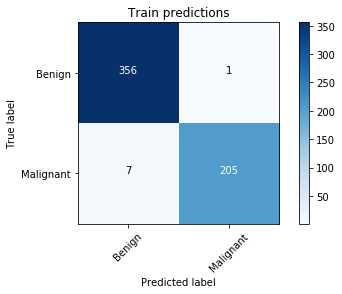

In [153]:
y_pred_all = grid_tree.best_estimator_.predict(df[features])
cm = confusion_matrix(df['diagnosis'],y_pred_all)
classes = ['Benign','Malignant']
plot_confusion_matrix(cm, classes, title="Train predictions", normalize=False)

Confusion Matrix, without normalization
[[346  11]
 [ 54 158]]


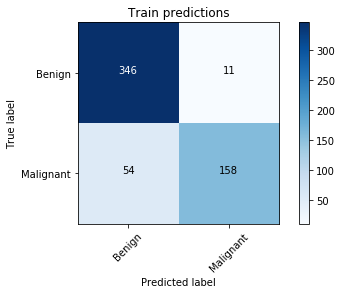

In [152]:

logreg = LogisticRegression()
logreg.fit(df[['radius_mean']],df['diagnosis'])
basic_pred = logreg.predict(df[['radius_mean']])
basic_cm = confusion_matrix(df['diagnosis'],basic_pred)
classes = ['Benign','Malignant']
plot_confusion_matrix(basic_cm, classes, title="Train predictions", normalize=False)

In [166]:
log_scaled_features = ['perimeter_mean','low_radius_mean','high_radius_mean','feature_interaction_worst',
                 'compactness_mean','concave points_mean','radius_worst','percent_higher_worst']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(df[log_scaled_features], df['diagnosis'])
scaler = StandardScaler()
scaler.fit(X_train_log)
X_train_log = scaler.transform(X_train_log)
X_test_log = scaler.transform(X_test_log)
logreg = LogisticRegression()
logreg.fit(X_train_log,y_train_log)
y_pred_log = logreg.predict(X_test_log)
f1_score(y_pred_log, y_test_log)

0.9423076923076923

Confusion Matrix, without normalization
[[88  2]
 [ 4 49]]


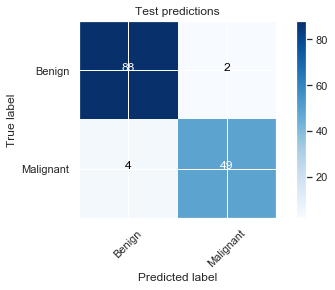

In [170]:
import importlib
importlib.reload(plt); importlib.reload(sns)
logistic_cm = confusion_matrix(y_test_log,y_pred_log)
classes = ['Benign','Malignant']
plot_confusion_matrix(logistic_cm, classes, title="Test predictions", normalize=False)